# Human Activity Recognition
This notebook provides some guidelines for building a classifier for the MotionSense dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split

# Generate time-series data
The original MotionSense dataset comes in a slightly cumbersome format, but the authors do provide a few functions to produce Pandas DataFrames with control over what is produced. For our purposes we are not concerned with all of the target data, as we only need to know the activity that was being recorded. 

In [2]:
## Load MotionSense data
def load_motion_sense_data():
    """
    Loads the MotionSense dataset from CSV files located in subdirectories named after activities.
    Each file is a recording of one subject performing the activity.

    Returns:
        A single pandas DataFrame containing all the loaded data with an added 'activity' column.
    """
    all_data = []
    for activity in ACTIVITIES:
        folder = os.path.join(DATA_PATH, activity)
        for file in os.listdir(folder):
            if file.endswith(".csv"):
                df = pd.read_csv(os.path.join(folder, file))
                df['activity'] = activity  # Label each row with its activity
                all_data.append(df)
    data = pd.concat(all_data, ignore_index=True)  # Combine all dataframes into one
    return data

def get_ds_infos():
    """
    Loads subject information from a CSV file, such as weight, height, age, and gender.

    Returns:
        A pandas DataFrame that contains information about data subjects' attributes.
        If the file is not found, returns dummy subject codes from 1 to 24.
    """
    try:
        dss = pd.read_csv(r"C:\Users\abdul\OneDrive - University of Cape Town\Varsity Work\2025 (4th Year)\EEE4114F\ML Project\data\data_subjects_info.csv")
        print("[INFO] -- Data subjects' information loaded.")
    except FileNotFoundError:
        print("[WARNING] -- data_subjects_info.csv not found. Using dummy subject codes 1–24.")
        dss = pd.DataFrame({"code": list(range(1, 25))})
    return dss

def set_data_types(data_types=["userAcceleration"]):
    """
    Defines which sensor data columns to include based on the selected sensor types.

    Args:
        data_types: List of sensor types to include. Options: ['attitude', 'gravity', 'rotationRate', 'userAcceleration'].

    Returns:
        A list of column names (as sublists of x/y/z or roll/pitch/yaw) to be used in time-series creation.
    """
    dt_list = []
    for t in data_types:
        if t != "attitude":
            dt_list.append([t + ".x", t + ".y", t + ".z"])
        else:
            dt_list.append([t + ".roll", t + ".pitch", t + ".yaw"])
    return dt_list

def create_time_series(dt_list, act_labels, trial_codes, mode="mag", labeled=True):
    """
    Creates a time-series dataset from the raw sensor data.

    Args:
        dt_list: A list of column names grouped by sensor type (from set_data_types()).
        act_labels: List of activity names (used as folder/file names).
        trial_codes: List of trial numbers for each activity.
        mode: 'raw' for full axis data or 'mag' for magnitude only.
        labeled: Whether to include activity labels in the dataset.

    Returns:
        A pandas DataFrame containing the time-series sensor data (and labels if labeled=True).
    """
    # Determine number of output columns based on mode
    num_data_cols = len(dt_list) if mode == "mag" else len(dt_list * 3)

    # Initialize an empty dataset with or without label column
    dataset = np.zeros((0, num_data_cols + 1)) if labeled else np.zeros((0, num_data_cols))
    
    ds_list = get_ds_infos()  # Get subject IDs or attributes

    print("[INFO] -- Creating Time-Series")
    for sub_id in ds_list["code"]:  # For each subject
        for act_id, act in enumerate(act_labels):  # For each activity
            for trial in trial_codes[act_id]:  # For each trial of the activity
                fname = (
                    r'C:\Users\abdul\OneDrive - University of Cape Town\Varsity Work\2025 (4th Year)\EEE4114F\ML Project\data\A_DeviceMotion_data\\'
                    + act + '_' + str(trial) + '\\sub_' + str(int(sub_id)) + '.csv'
                )
                raw_data = pd.read_csv(fname)  # Load trial data
                raw_data = raw_data.drop(['Unnamed: 0'], axis=1)  # Drop unnecessary index column
                
                # Initialize an array for sensor values
                vals = np.zeros((len(raw_data), num_data_cols))
                
                for x_id, axes in enumerate(dt_list):
                    if mode == "mag":
                        # Compute magnitude: sqrt(x^2 + y^2 + z^2)
                        vals[:, x_id] = (raw_data[axes]**2).sum(axis=1)**0.5        
                    else:
                        # Include raw x, y, z (or roll, pitch, yaw) values
                        vals[:, x_id*3:(x_id+1)*3] = raw_data[axes].values
                
                # Ensure correct shape
                vals = vals[:, :num_data_cols]
                
                # Add activity labels if needed
                if labeled:
                    lbls = np.array([[act_id]] * len(raw_data))  # Create label array
                    vals = np.concatenate((vals, lbls), axis=1)
                
                # Append to final dataset
                dataset = np.append(dataset, vals, axis=0)

    # Define column names based on sensor types and mode
    cols = []
    for axes in dt_list:
        if mode == "raw":
            cols += axes
        else:
            cols += [str(axes[0][:-2])]  # Use sensor name (remove ".x" etc.)
    
    if labeled:
        cols += ["act"]  # Add label column
    
    # Convert final dataset to a DataFrame
    dataset = pd.DataFrame(data=dataset, columns=cols)
    return dataset

You would need to decide what to include in your dataset, for example if you want to try a reduce dataset with only a few sensors then you can alter the `sdt` list. 

In [3]:
ACT_LABELS = ["dws","ups", "wlk", "jog", "std", "sit"]
TRIAL_CODES = {
    ACT_LABELS[0]: [1, 2, 11],
    ACT_LABELS[1]: [3, 4, 12],
    ACT_LABELS[2]: [7, 8, 15],
    ACT_LABELS[3]: [9, 16],
    ACT_LABELS[4]: [6, 14],
    ACT_LABELS[5]: [5, 13],
}

# Select sensor types
selected_sensors = ["attitude", "userAcceleration"]
print("[INFO] -- Selected sensor types:", selected_sensors)

# Select subset of activities (just the first four for now)
act_labels = ACT_LABELS[:6]
trial_codes = [TRIAL_CODES[act] for act in act_labels]
dt_list = set_data_types(selected_sensors)

# Generate the labeled dataset
dataset = create_time_series(dt_list, act_labels, trial_codes, mode="raw", labeled=True)

print("[INFO] -- Dataset shape:", dataset.shape)
display(dataset.head())

[INFO] -- Selected sensor types: ['attitude', 'userAcceleration']
[INFO] -- Data subjects' information loaded.
[INFO] -- Creating Time-Series
[INFO] -- Dataset shape: (1412865, 7)


,attitude.roll,attitude.pitch,attitude.yaw,userAcceleration.x,userAcceleration.y,userAcceleration.z,act
0,1.528132,-0.733896,0.696372,0.294894,-0.184493,0.377542,0.0
1,1.527992,-0.716987,0.677762,0.219405,0.035846,0.114866,0.0
2,1.527765,-0.706999,0.670951,0.010714,0.134701,-0.167808,0.0
3,1.516768,-0.704678,0.675735,-0.008389,0.136788,0.094958,0.0
4,1.493941,-0.703918,0.672994,0.199441,0.353996,-0.044299,0.0


# Data Pre-processing
There are numerous approaches to solving this task and your choice of algorithm will determine what form your input data should take. For example, a feed-forward neural network could be used, but what type of representation would make sense? Without being able to account for the temporal structure of the data, feed-forward networks might fail. One way around this is to potentially use summarized statistics about the data to simplify the features in a way that is not reliant on temporal information. E.g. instead of the raw signal for the acceleration, what if you worked with the mean? This might not be the best approach, compared to other algorithms, but it could be useful for a feed-forward network.

what about convolutional neural networks? Well, you could use 1D convolutions directly on time-series data which would then result in fewer model parameters compared to a fully-connected network, with the added benefit of retaining temporal information. Alternatively you could look to transform the time-series data into 2D data using something such as an FFT to produce a spectogram. Or for something simpler you can create fixed windows to divide your dataset into chunks of 2D data e.g. for 6 sensors and a window of 400 samples you would generate a 6 x 400 input. 

In [4]:
def windows(dataset, window_size=400, stride=200):
    """
    Splits the continuous time-series dataset into overlapping fixed-length windows.

    Args:
        dataset: A pandas DataFrame with sensor values and an 'act' column for labels.
        window_size: Number of samples in each sliding window.
        stride: Step size for sliding the window (overlap = window_size - stride).

    Returns:
        X: Numpy array of shape (n_windows, window_size, n_features) containing sensor data.
        y: Numpy array of shape (n_windows,) containing one label per window.
    """
    # Identify sensor columns by excluding the 'act' label column
    sensor_columns = dataset.columns.difference(['act'])
    
    X = []  # List to store windowed sensor data
    y = []  # List to store labels corresponding to each window

    # Slide the window across the dataset
    for start in range(0, len(dataset) - window_size + 1, stride):
        end = start + window_size  # Define window end position
        window = dataset.iloc[start:end]  # Extract the window

        if len(window) < window_size:
            # Skip if the window is incomplete (usually not necessary due to loop range)
            continue

        # Extract sensor data from the window as a NumPy array
        sensor_data = window[sensor_columns].values  # Shape: (window_size, n_features)

        # Assign a label to the window using the most frequent activity (majority vote)
        # Alternative: window['act'].iloc[window_size // 2] to take the central label
        label = window['act'].mode()[0]

        # Store windowed data and its label
        X.append(sensor_data)
        y.append(label)

    # Convert lists to NumPy arrays for model input
    X = np.array(X)  # Final shape: (num_windows, window_size, num_features)
    y = np.array(y)  # Final shape: (num_windows,)

    return X, y

# Pytorch Dataset
If using Pytorch it is useful to create datasets using their dataset structures. This may require modification if using additional transformations, or formats

In [5]:
class MotionSense(Dataset):
    def __init__(self, X, Y, transform=None):
        self.X = torch.tensor(X.values)
        self.Y = torch.tensor(Y.values)
        self.transform = transform

    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = int(index.item())

        x = self.X[index]
        y = self.Y[index]

        return x, y

    def __len__(self):
        return len(self.X)

# Resampling
You can split the dataset using sklearn, but you need to take care with your specific data. For example, randomly splitting raw sensor data will result in jumbled time-series signals. 

In [6]:
X = dataset[dt_list[0]] # You could collect the input and target data as separate dataframes
Y = dataset.act

In [7]:
# You may be tempted to use train_test_split directly. But if using raw sensor data this would randomize the signals and not retain the order. 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1) 

In [8]:
X_train.head() 

,attitude.roll,attitude.pitch,attitude.yaw
395344,-1.324215,-1.389730,-1.453904
1408277,-2.668836,-0.084761,-0.419726
169899,1.563905,-1.210553,1.433881
1074984,-0.772627,-1.062402,0.279778
535044,1.272401,-0.873645,2.826670


Notice the indeces are all jumbled? If using windowed data the usual splitting methods work, as each window retains the order of sensor values, as long as you split the data along the correct axis. 

If using summarized data e.g. taking the mean, max, min etc. as input features rather than the raw data then you should be fine using train_test_split.

If working with raw sensor data there is an sklearn fuction for splitting time series data to make splitting raw signals easier if you want to work with that instead.

In [9]:
# Here is an example of the TimeSeriesSplit. It does create cross-validation data by default. 
ts_cv = TimeSeriesSplit(
    n_splits=5,
    gap=20,
    max_train_size=10000,
    test_size=1000
)

all_splits = list(ts_cv.split(X ,Y)) # These are indices, not the data itself.

Once you have the indices you can sample the data

In [10]:
X.iloc[all_splits[0][0]].head() # This is the training input data from the first split

,attitude.roll,attitude.pitch,attitude.yaw
1397845,-0.958415,-1.273400,2.505994
1397846,-0.960113,-1.272760,2.506021
1397847,-0.961836,-1.272516,2.506426
1397848,-0.961993,-1.272238,2.508011
1397849,-0.959931,-1.272258,2.511630


In [11]:
Y.iloc[all_splits[0][0]].head() # This is the training target data from the first split. You can see the indices still match, and arre ordered correctly.

1397845    4.0
1397846    4.0
1397847    4.0
1397848    4.0
1397849    4.0
Name: act, dtype: float64

Once you have your splits, you can convert them to Pytorch datasets for easier loading. Technically you could offload the sampling methods to Pytorch samplers, but this can be trickier to implement.

In [12]:
train_1 = MotionSense(X.iloc[all_splits[0][0]].reset_index(drop=True), 
                      Y.iloc[all_splits[0][0]].reset_index(drop=True)) # reset_index is to make sure each new set is indexed from 0
train_1_loader = DataLoader(train_1, batch_size=5)  # Will load data in batches. Batching raw signals can be problematic if it cuts-off a given signal, or stitches it together with other signals etc.

# Models
As mentioned previously there are a few options for the types of models you end up using.

In [13]:
class CNNNet(nn.Module):
    def __init__(self, n_features, n_classes):
        """
        Initializes a 1D Convolutional Neural Network for time-series classification.

        Args:
            n_features: Number of input features per time step (e.g., 3 for accel mag, 9 for full raw set).
            n_classes: Number of output classes (activities).
        """
        super(CNNNet, self).__init__()
        
        # First 1D convolution layer
        # Input shape: (batch_size, n_features, seq_len)
        self.conv1 = nn.Conv1d(
            in_channels=n_features,  # number of input channels (features)
            out_channels=64,         # number of output channels
            kernel_size=5,           # kernel size along time
            stride=1,
            padding=2                # to maintain input length
        )
        self.bn1 = nn.BatchNorm1d(64)  # Batch normalization for regularization
        self.pool1 = nn.MaxPool1d(kernel_size=2)  # Reduces sequence length by 2

        # Second 1D convolution layer
        self.conv2 = nn.Conv1d(
            in_channels=64,
            out_channels=128,
            kernel_size=5,
            stride=1,
            padding=2
        )
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(kernel_size=2)

        # Dropout for regularization
        self.dropout = nn.Dropout(0.5)

        # Fully connected layer 1
        # Input: flattened feature map after conv and pooling
        # Assumes input sequence length is 400 -> after 2x maxpool (each halves size): 400 -> 200 -> 100
        self.fc1 = nn.Linear(128 * 100, 256)  # 128 channels × 100 time steps

        # Final output layer
        self.fc2 = nn.Linear(256, n_classes)

    def forward(self, x):
        """
        Defines the forward pass of the network.

        Args:
            x: Input tensor of shape (batch_size, seq_len, n_features)

        Returns:
            Output logits of shape (batch_size, n_classes)
        """
        x = x.permute(0, 2, 1)  # Reshape to (batch_size, n_features, seq_len) for Conv1d
        
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))  # Conv -> BN -> ReLU -> Pool
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))  # Conv -> BN -> ReLU -> Pool

        x = self.dropout(x)  # Apply dropout
        
        x = x.view(x.size(0), -1)  # Flatten for fully connected layers

        x = F.relu(self.fc1(x))  # FC + ReLU
        x = self.fc2(x)          # Final output layer (logits)
        return x

In [14]:
X, y = windows(dataset, window_size=400, stride=200)
print(X.shape)  # should be (n_samples, 400, n_features)

(7063, 400, 6)


In [15]:
n_features = X.shape[2]  # e.g., 6 if 3-axis acc + 3-axis gyro
n_classes = len(np.unique(y))

model = CNNNet(n_features=n_features, n_classes=n_classes)

# Training
With your model defined you will need to decide on an optimizer used to perform parameter updates. The choice is yours, but for the most part default optimizers like Adam should work for CNNs, although SGD can be more stable but take longer to train. 

You can then load in data, for example if using the loader described before the loop shown below will iterate through batches of data. 

In [16]:
# Custom Dataset class for sliding window HAR dataset
class HARWindowDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X: Numpy array of shape (n_samples, window_size, n_features)
            y: Numpy array of labels (n_samples,)
        """
        self.X = torch.tensor(X, dtype=torch.float32)  # Convert features to float tensors
        self.y = torch.tensor(y, dtype=torch.long)     # Convert labels to long tensors (required for CrossEntropyLoss)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Return one sample and its label
        return self.X[idx], self.y[idx]

# Split data into training and test sets (stratified to maintain class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Create dataset objects
train_dataset = HARWindowDataset(X_train, y_train)
test_dataset = HARWindowDataset(X_test, y_test)

# Create DataLoaders for batching and shuffling
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Use GPU if available, otherwise fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to appropriate device
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Suitable for multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
num_epochs = 10
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    # --- Training Phase ---
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # --- Validation Phase ---
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for val_inputs, val_labels in test_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)

            val_outputs = model(val_inputs)
            loss = criterion(val_outputs, val_labels)
            val_loss += loss.item()

            _, val_predicted = torch.max(val_outputs, 1)
            val_correct += (val_predicted == val_labels).sum().item()
            val_total += val_labels.size(0)

    val_epoch_loss = val_loss / len(test_loader)
    val_epoch_acc = val_correct / val_total
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_acc)

    # Print both training and validation stats
    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f} - "
          f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")

Epoch 1/10 - Train Loss: 0.6009, Train Acc: 0.7811 - Val Loss: 0.3216, Val Acc: 0.8811
Epoch 2/10 - Train Loss: 0.2254, Train Acc: 0.9120 - Val Loss: 0.2799, Val Acc: 0.8931
Epoch 3/10 - Train Loss: 0.1779, Train Acc: 0.9370 - Val Loss: 0.1500, Val Acc: 0.9547
Epoch 4/10 - Train Loss: 0.1152, Train Acc: 0.9618 - Val Loss: 0.1505, Val Acc: 0.9469
Epoch 5/10 - Train Loss: 0.1157, Train Acc: 0.9627 - Val Loss: 0.1803, Val Acc: 0.9434
Epoch 6/10 - Train Loss: 0.0775, Train Acc: 0.9738 - Val Loss: 0.2188, Val Acc: 0.9292
Epoch 7/10 - Train Loss: 0.0705, Train Acc: 0.9745 - Val Loss: 0.1283, Val Acc: 0.9568
Epoch 8/10 - Train Loss: 0.0359, Train Acc: 0.9880 - Val Loss: 0.1257, Val Acc: 0.9653
Epoch 9/10 - Train Loss: 0.0279, Train Acc: 0.9913 - Val Loss: 0.2048, Val Acc: 0.9413
Epoch 10/10 - Train Loss: 0.0523, Train Acc: 0.9819 - Val Loss: 0.1458, Val Acc: 0.9554


# Evaluation
Make sure to correctly evaluate your models. Justify your methods given your particular model and data used e.g. if you use random holdout, is it justified? What do your performance metrics tell you e.g. was the model overfitting, underfitting, are their early stages in the training process where the model performs well compared to the end of training, which model do you choose to save, are the model outputs "reasonable" i.e. are there errors that might make sense given the data? 

              precision    recall  f1-score   support

           0       0.89      0.92      0.90       131
           1       0.95      0.78      0.85       158
           2       0.91      0.98      0.94       344
           3       0.98      0.98      0.98       134
           4       0.99      0.99      0.99       307
           5       1.00      0.99      0.99       339

    accuracy                           0.96      1413
   macro avg       0.95      0.94      0.94      1413
weighted avg       0.96      0.96      0.95      1413



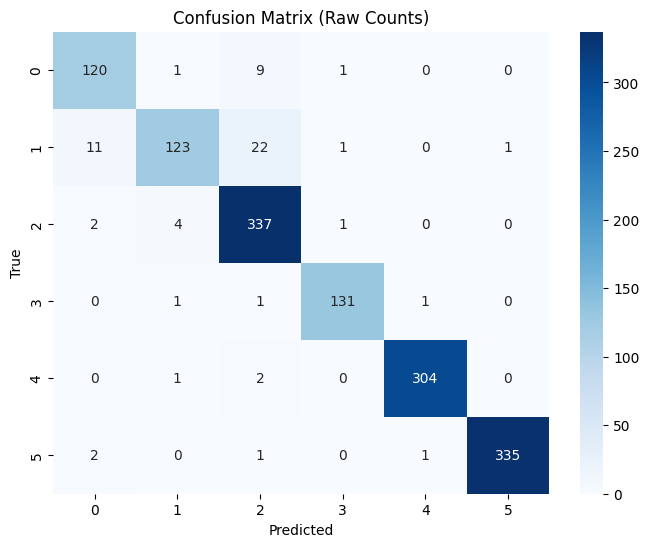

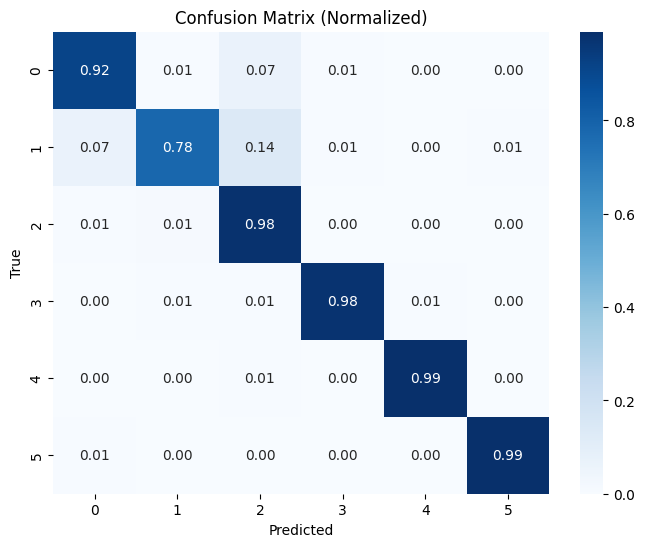

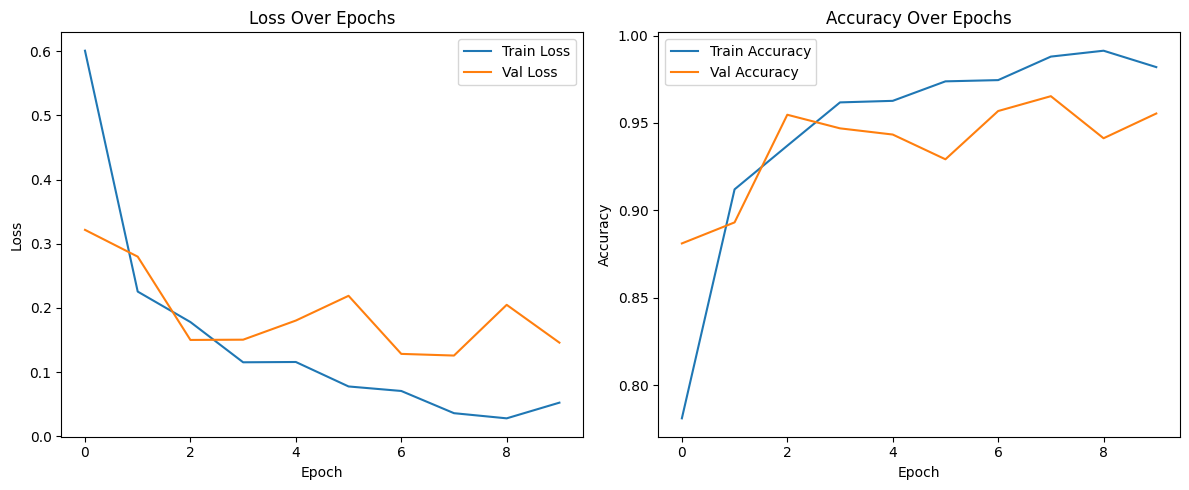

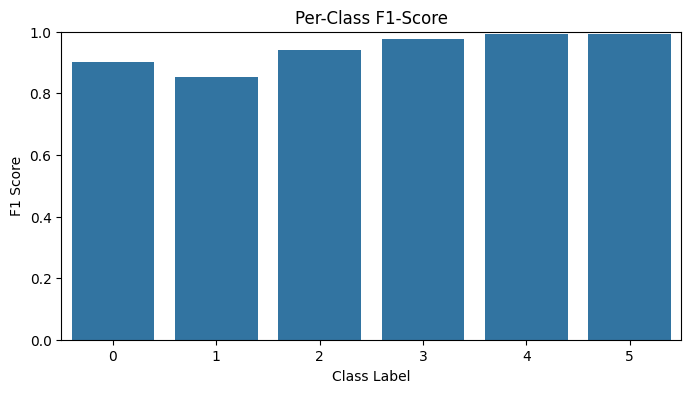

In [17]:
# --- Set model to evaluation mode ---
model.eval()
all_preds = []
all_labels = []

# Disable gradient computation for efficiency during inference
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)  # Move input data to device (GPU or CPU)
        outputs = model(inputs)     # Forward pass
        _, predicted = torch.max(outputs, 1)  # Get predicted class label
        all_preds.extend(predicted.cpu().numpy())  # Store predictions
        all_labels.extend(labels.numpy())          # Store true labels

# --- Generate and Print Classification Report ---
# Gives precision, recall, f1-score per class and overall metrics
report = classification_report(all_labels, all_preds, output_dict=True)
print(classification_report(all_labels, all_preds))

# --- Plot Confusion Matrix (Raw Counts) ---
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Raw Counts)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# --- Plot Normalized Confusion Matrix ---
# Normalizing each row to show percentage of predictions per actual class
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 6))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues')
plt.title("Confusion Matrix (Normalized)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# --- Plot Training vs Validation Loss and Accuracy ---
# Assumes `val_losses` and `val_accuracies` are populated during training
plt.figure(figsize=(12, 5))

# Plot loss over epochs
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')  # Validation loss (if tracked)
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot accuracy over epochs
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')  # Validation accuracy (if tracked)
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

# --- Optional: Plot Per-Class F1 Scores ---
# Useful for seeing which classes the model performs well or poorly on
classes = list(report.keys())[:-3]  # Exclude 'accuracy', 'macro avg', 'weighted avg'
f1_scores = [report[cls]['f1-score'] for cls in classes]

plt.figure(figsize=(8, 4))
sns.barplot(x=classes, y=f1_scores)
plt.title("Per-Class F1-Score")
plt.xlabel("Class Label")
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.show()